# Comparing Up Slope Flux Methods

This program takes data from the Radiosondes balloon launches and compares it with precipitation data from ESRL. It also gives different ways to examine the data. Originally, the analysis was written in MATLAB code. However, it is very unorganized and hard to follow. This file is a rewriting of that MATLAB code. This lays the groundwork for the analysis I preformed with the MATLAB code and should allow for further research on this topic. While the code is not as comprehensive as the matlab code I had written, it is much more organized and well written.

In [1]:
# Run this cell first to prepare the program and assign the proper data folder

import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import pandas
import time

#This is designed to pick a folder from within the folder that the python code is running from.
data_folder = 'Bulk Upslope Flux Data'
#Change the directory to the data folder
os.chdir(data_folder)

#Variables and Constants
R_v = 461.51;
g = 9.8; #gravity
angle = 230; #desired upslope angle to mountains in degrees
# -cosd(angle) ; wind V component of Upslope unit vector 
# -sind(angle) ; wind U component of upslope unit vector
P_limit = 300*100; #program will evaluate up to this minimum pressure (needs to be in Pa)

In [2]:
#Grab filenames of the radiosondes data, there are two different types of names over the years used
filename = np.array([glob.glob('Rdio*.txt'),glob.glob('raob*.txt')])
filename = np.concatenate(filename)

In [3]:
#Make an array that contains each data profile
data_files = np.empty(len(filename),dtype='object')
for ii in range(len(filename)):
    data_files[ii] = np.genfromtxt(filename[ii],skip_header=14,skip_footer=1)
    
# for reference:
# columns: 0 = #, 1 = p (hPa), 2 = Height (m), 3 = Temp (C), 4 = RH, 5 = Wind dir(angle in degrees from N going clockwise)
#          6 = Wind speed (m/s), 7 = U (west to east wind speed), 8 = V (South to North wind speed)

In [4]:
#Make arrays for ESRL data for each year
ESRL_2016 = np.genfromtxt('2016_aggregate.txt',delimiter=',')
ESRL_2017 = np.genfromtxt('2017_aggregate.txt',delimiter=',')
ESRL_2018 = np.genfromtxt('2018_aggregate.txt',delimiter=',')
ESRL_2019 = np.genfromtxt('2019_aggregate.txt',delimiter=',')

#optional step, remove NaNs from data
ESRL_2016 = ESRL_2016[~np.isnan(ESRL_2016[:,0])]
ESRL_2017 = ESRL_2017[~np.isnan(ESRL_2017[:,0])]
ESRL_2018 = ESRL_2018[~np.isnan(ESRL_2018[:,0])]
ESRL_2019 = ESRL_2019[~np.isnan(ESRL_2019[:,0])]

#for reference
#columns: 2 = day of the year, 3 = time of day (hrmn), 14 = precipitation

In [5]:
#Eliminate data profiles that don't go up to minimum pressure
P_min_list = np.zeros(len(data_files))
for ii in range(len(data_files)):
    P_min_list[ii] = min(data_files[ii][:,1])

#replace current data_files and filename with indices that go to the minimum pressure
data_files = data_files[np.where(P_min_list <= P_limit/100)]
filename = filename[np.where(P_min_list <= P_limit/100)]

## Functions

In [6]:
def Find_USF(data,angle = 230,p_max = 1000*100,p_min = 300*100):
    """
    This function takes data from a profile and returns the UpSlope Flux(USF) calculated 
    in two different methods. What we call the Radiosondes or Balloon method uses the whole 
    range of wind and water vapor to calculate the USF. The Ralph method uses the IWV 
    calculated from the whole column but uses wind from a control layer. This function also
    gives an array of the results and measurements.
    
    Assumes control layer for Ralph method to be between 750m and 1250m.
    
    ARGUMENTS:
    ================================================================
    data - single profile of radiosondes data as an np.array table
    angle - angle that is the direction of the upslope
    p_max - maximum pressure to take in data (lowest altitude)
    p_min - minimum pressure to take in data (highest altitude)
    
    RETURNS:
    ================================================================
    an array of useful information, the lists are reduced to the values between pressure limits
    array = [USF_B,USF_R,IWV,q,Wcom,Tk_pot,Tk_eq_pot,p,Z,Tk,RH]
    array[0] = USF_B - Uplsolpe flux balloon method
    array[1] = USF_R - Upslope flux Ralph method
    array[2] = IWV - Integrated Water Vapor
    array[3] = q (list) - specific humidity
    array[4] = Wcom (list) - Wind component in the direction of the upslope angle
    array[5] = Tk_pot (list) - potential temperature in Kelvin
    array[6] = Tk_eq_pot (list) - equivalent potential temperature
    array[7] = p (list) - pressure (Pa)
    array[8] = Z (list) - height (m)
    array[9] = Tk (list) - Temperature (K)
    array[10] = RH (list) - Relative Humidity as a ratio
    note that the lists here will only be between the p limits
    
    GLOBAL VARIABLES:
    ================================================================
    g - gravity
    
    """
    
    #define the variables and eliminate NaN values
    p = data[:,1]*100 #Pressure in Pa  
    use_ind = ~np.isnan(p) #this variable is a truth table for valid indices where p is not NaN.
    p = p[use_ind]
    Z = data[:,2] #height in meters
    Z = Z[use_ind]
    T = data[:,3] #Temp in Celsius
    T = T[use_ind]
    Tk = T + 273.15 #Temp in Kelvin
    RH = data[:,4]/100 #relative humidity as a ratio, not percentage
    RH = RH[use_ind]
    Wdir = data[:,5] #wind direction as an angle
    Wdir = Wdir[use_ind]
    Wspd = data[:,6] #wind speed in m/s
    Wspd = Wspd[use_ind]
    U = data[:,7] #west to east wind speed m/s
    U = U[use_ind]
    V = data[:,8] #south to north wind speed m/s
    V = V[use_ind]
        
    #Eliminate data that comes from the balloon falling back down
    p = p[0:np.where(p == min(p))[0][0]] #find index of min pressure and only keep indices before that.
    
    #create indices that are within pressure limits.
    p_limit_ind = np.where((p_max >= p) & (p >= p_min))[0]
    #change variables to only included used indices
    p = p[p_limit_ind]
    Z = Z[p_limit_ind]
    T = T[p_limit_ind]
    Tk = Tk[p_limit_ind]
    RH = RH[p_limit_ind]
    Wdir = Wdir[p_limit_ind]
    Wspd = Wspd[p_limit_ind]
    U = U[p_limit_ind]
    V = V[p_limit_ind]
    
    #some variables which are explained in the report
    e_s = 100*6.11*np.exp(5420*(1/273 - 1/(Tk))) #Partial pressure of saturated water vapor in Pa
    w_s = 0.622*e_s/(p-e_s) #saturated mixing ratio of water vapor
    w = RH*w_s #mixing ratio of water vapor
    q = w/(1+w) #specific humidity
    
    Tk_pot = Tk*np.power((100000/p),(0.286)); #potential temperature (eq 3.54)
    Tk_eq_pot = Tk_pot*np.exp(w*2600000/(1004*Tk)); #equivalent potential temperature 
                                                     #using values 2500kJ/kg for L_v 
                                                     #and 1004 J/kg/K for c (eq 3.71)
    
    Wcom = Wspd*np.cos(np.deg2rad(angle - Wdir)) #component of wind parallel with upslope direction
    
    #find Integrated Water Vapor (IWV)
    IWV = 0
    for ii in range(0,len(p)-1): 
        q_mean = (q[ii] + q[ii+1])/2.0
        p_diff = p[ii] - p[ii+1]
        
        IWV = IWV + q_mean*p_diff/g
        
    #find USF_B (Balloon method)
    USF_B = 0
    for ii in range(0,len(p)-1):
        q_mean = (q[ii] + q[ii+1])/2
        p_diff = p[ii] - p[ii+1]
        Wcom_mean = (Wcom[ii]+Wcom[ii+1])/2
        USF_B = USF_B + Wcom_mean*q_mean*p_diff/g
        
    #find USF_R (Ralph method)
    ctrl_lyr = 0 #average of wind
    count = 0
    p_ctrl_lyr = p[np.where((1250 >= Z) & (Z >= 750))[0]]#ralph ctrl lyr limits
    p_ctrl_lyr_total = p_ctrl_lyr[0] - p_ctrl_lyr[-1] #difference between pressures at ends of ctrl lyr
    Wcom_ctrl_lyr = Wcom[np.where((1250 >= Z) & (Z >= 750))[0]]
    
    #use weighted average to calculate ctrl layer, weighted by pressure compared to total pressure difference
    for ii in range(0,len(p_ctrl_lyr)-2):
        Wcom_mean = (Wcom_ctrl_lyr[ii] + Wcom_ctrl_lyr[ii+1])/2
        p_diff = p_ctrl_lyr[ii] - p_ctrl_lyr[ii+1]
        ctrl_lyr = ctrl_lyr + Wcom_mean*p_diff/p_ctrl_lyr_total
        
    USF_R = IWV*ctrl_lyr
    
    return [USF_B,USF_R,IWV,q,Wcom,Tk_pot,Tk_eq_pot,p,Z,Tk,RH]





def Find_USF_interp(data,angle = 230,p_max = 1000*100,p_min = 300*100):
    """
    This function is identical to Find_USF except that it linearly interpolates the data according to 
    pressure. 
    
    Assumes control layer for Ralph method to be between 750m and 1250m.
    
    ARGUMENTS:
    ================================================================
    data - single profile of radiosondes data as an np.array table
    angle - angle that is the direction of the upslope
    p_max - maximum pressure to take in data (lowest altitude)
    p_min - minimum pressure to take in data (highest altitude)
    
    RETURNS:
    ================================================================
    an array of useful information, the lists are reduced to the values between 
    pressure limits and interpolated
    
    array = [USF_B,USF_R,IWV,q,Wcom,Tk_pot,Tk_eq_pot,p,Z,Tk,RH]
    array[0] = USF_B - Uplsolpe flux balloon method
    array[1] = USF_R - Upslope flux Ralph method
    array[2] = IWV - Integrated Water Vapor
    array[3] = q (list) - specific humidity
    array[4] = Wcom (list) - Wind component in the direction of the upslope angle
    array[5] = Tk_pot (list) - potential temperature in Kelvin
    array[6] = Tk_eq_pot (list) - equivalent potential temperature
    array[7] = p(list) - pressure (Pa) NOTE this list is always the same for interpolation
    array[8] = Z (list) - height (m)
    array[9] = Tk (list) - Temperature (K)
    array[10] = RH (list) - Relative Humidity as a ratio
    note that the lists here will only be between the p limits
    
    GLOBAL VARIABLES:
    ================================================================
    g - gravity, 9.8m/s
    
    """
    #define variables
    p = data[:,1]*100 #Pressure in Pa  
    use_ind = ~np.isnan(p) #this variable is a truth table for valid indices where p is not NaN.
    p = p[use_ind]
    Z = data[:,2] #height in meters
    Z = Z[use_ind]
    T = data[:,3] #Temp in Celsius
    T = T[use_ind]
    Tk = T + 273.15 #Temp in Kelvin
    RH = data[:,4]/100 #relative humidity as a ratio, not percentage
    RH = RH[use_ind]
    Wdir = data[:,5] #wind direction as an angle
    Wdir = Wdir[use_ind]
    Wspd = data[:,6] #wind speed in m/s
    Wspd = Wspd[use_ind]
    U = data[:,7] #west to east wind speed m/s
    U = U[use_ind]
    V = data[:,8] #south to north wind speed m/s
    V = V[use_ind]
        
    #Eliminate data that comes from the balloon falling back down
    p = p[0:np.where(p == min(p))[0][0]] #find index of min pressure and only keep indices before that.
    #make the rest of the values the same length
    Z = Z[0:len(p)]
    T = T[0:len(p)]
    Tk = Tk[0:len(p)]
    RH = RH[0:len(p)]
    Wdir = Wdir[0:len(p)]
    Wspd = Wspd[0:len(p)]
    U = U[0:len(p)]
    V = V[0:len(p)]
    
    #interpolate the data
    xp = np.arange(p_min,p_max+1,1) #python interpolation needs to be an increasing array
    Z = np.flip(np.interp(xp,np.flip(p),np.flip(Z))) #and since pressure is decreasing
    T = np.flip(np.interp(xp,np.flip(p),np.flip(T))) #we reverse the order of all the values 
    Tk = np.flip(np.interp(xp,np.flip(p),np.flip(Tk))) #and then flip them back
    RH = np.flip(np.interp(xp,np.flip(p),np.flip(RH)))
    Wdir = np.flip(np.interp(xp,np.flip(p),np.flip(Wdir)))
    Wspd = np.flip(np.interp(xp,np.flip(p),np.flip(Wspd)))
    U = np.flip(np.interp(xp,np.flip(p),np.flip(U)))
    V = np.flip(np.interp(xp,np.flip(p),np.flip(V)))
    p = np.flip(xp)
    

    e_s = 100*6.11*np.exp(5420*(1/273 - 1/(Tk))) #Partial pressure of saturated water vapor in Pa
    w_s = 0.622*e_s/(p-e_s) #saturated mixing ratio of water vapor
    w = RH*w_s #mixing ratio of water vapor
    q = w/(1+w) #specific humidity
    
    Tk_pot = Tk*np.power((100000/p),(0.286)); #potential temperature (eq 3.54)
    Tk_eq_pot = Tk_pot*np.exp(w*2500000/(1004*Tk)); #equivalent potential temperature 
                                                     #using values 2500kJ/kg for L_v 
                                                     #and 1004 J/kg/K for c (eq 3.71)
    
    Wcom = Wspd*np.cos(np.deg2rad(angle - Wdir)) #component of wind parallel with upslope direction
    
    #find Integrated Water Vapor (IWV)
    IWV = 0
    for ii in range(0,len(p)-1): 
        q_mean = (q[ii] + q[ii+1])/2.0
        p_diff = p[ii] - p[ii+1]
        
        IWV = IWV + q_mean*p_diff/g
        
    #find USF_B (Balloon method)
    USF_B = 0
    for ii in range(0,len(p)-1):
        q_mean = (q[ii] + q[ii+1])/2
        p_diff = p[ii] - p[ii+1]
        Wcom_mean = (Wcom[ii]+Wcom[ii+1])/2
        USF_B = USF_B + Wcom_mean*q_mean*p_diff/g
        
    #find USF_R (Ralph method)
    ctrl_lyr = 0 #average of wind
    count = 0
    p_ctrl_lyr = p[np.where((1250 >= Z) & (Z >= 750))[0]]#ralph ctrl lyr limits
    p_ctrl_lyr_total = p_ctrl_lyr[0] - p_ctrl_lyr[-1] #difference between pressures at ends of ctrl lyr
    Wcom_ctrl_lyr = Wcom[np.where((1250 >= Z) & (Z >= 750))[0]]
    
    #use weighted average to calculate ctrl layer, weighted by pressure compared to total pressure difference
    for ii in range(0,len(p_ctrl_lyr)-2):
        Wcom_mean = (Wcom_ctrl_lyr[ii] + Wcom_ctrl_lyr[ii+1])/2
        p_diff = p_ctrl_lyr[ii] - p_ctrl_lyr[ii+1]
        ctrl_lyr = ctrl_lyr + Wcom_mean*p_diff/p_ctrl_lyr_total
        
    USF_R = IWV*ctrl_lyr
    
    return [USF_B,USF_R,IWV,q,Wcom,Tk_pot,Tk_eq_pot,p,Z,Tk,RH]


def RS_data_date_time(file_name):
    """
    This function takes in the name of a Radiosondes file and returns the date and 
    time of launch from file. This assumes the directory is set to the folder with the data.
    
    ARGUMENTS:
    ================================================================
    file_name = name of file
    
    RETURNS:
    ================================================================
    an array with the date and time
    array = [year,day of the year,hour,minute]
    """
    
    month_list = np.array([31,28,31,30,31,30,31,31,30,31,30,31])
    month_list_L = np.array([31,29,31,30,31,30,31,31,30,31,30,31])
    test_file = open(file_name,'r')

    #skip first few lines
    for ii in range(0,4):
        test_file.readline()

    date_str = test_file.readline()
    time_str = test_file.readline()

    test_file.close()
    
    #since the line has characters that we don't want, we only use the ends of the lines
    #based on the format yyyymmdd
    day_month = int(date_str[len(date_str)-3:len(date_str)-1]) #day of the month
    month = int(date_str[len(date_str)-5:len(date_str)-3])
    year = int(date_str[len(date_str)-9:len(date_str)-5])

    #sets the time depending on if the file records seconds or not
    if len(time_str) > 21:
        second = int(time_str[len(time_str)-3:len(time_str)-1])
        minute = int(time_str[len(time_str)-5:len(time_str)-3])
        hour = float(time_str[len(time_str)-7:len(time_str)-5])
    else:
        second = 0
        minute = int(time_str[len(time_str)-3:len(time_str)-1])
        hour = int(time_str[len(time_str)-5:len(time_str)-3])

    #translates day of month to day of year depending on if it is a leap year or not
    if (year % 4 == 0) & (bool(year % 100 != 0) + bool(year % 400 == 0) == 1 ): #uses bool + bool == 1 for xor
        day_year = day_month + sum(month_list_L[0:month-1])
    else:
        day_year = day_month + sum(month_list[0:month-1])
    
    return [year,day_year,hour,minute]




## Analysis

#### Compare USF vs precipitation

these cells below provide the basis for comparing precipitation and up slope flux. From here you should be able to plot whatever data you need to or analyze values as necessary. 

In [7]:
#this cell makes an array that matches accumulated precipitation during a certain time period after the
#time of a radiosondes balloon launch

#--------------------------------------------------------------------------------------
#variables

#from previous experimenting we know the best time period is no offset and a period of 60 minutes
offset = 0
step_size = 60

range_min = 300
range_max = range_min + 100
#--------------------------------------------------------------------------------------

RS_time = np.zeros(len(filename));
RS_year = np.zeros(len(filename));

for ii in range(0,len(filename)):
    date = RS_data_date_time(filename[ii])
    #get time of year to the minute
    RS_time[ii] = (date[1]-1)*24*60 + date[2]*60 + date[3]
    RS_year[ii] = date[0]


#here we will convert the times to minutes of the year for ease of use
precip_data = [ESRL_2016[:,14],ESRL_2017[:,14],ESRL_2018[:,14],ESRL_2019[:,14]]
days_data = [ESRL_2016[:,2],ESRL_2017[:,2],ESRL_2018[:,2],ESRL_2019[:,2]]
times_data = [ESRL_2016[:,3],ESRL_2017[:,3],ESRL_2018[:,3],ESRL_2019[:,3]]

#this for loop adds the days, hours, and minutes together in terms of minutes
for ii in range(0,len(times_data)):
    times_data[ii] = (times_data[ii] % 100) + np.floor(times_data[ii]/100)*60 + (days_data[ii] -1)*60*24


p_period_RS = np.zeros(len(RS_time))

for ii in range(0,len(RS_time)):
    #check if year is outside range we are using
    if ((int(RS_year[ii]) - 2016)> 3) | (0 > (int(RS_year[ii]) - 2016)): 
        raise ValueError('invalid year')
    else:
        precip = precip_data[int(RS_year[ii]) - 2016]
        times = times_data[int(RS_year[ii]) - 2016]
    
    # test if period is a valid data point by checking if there are data
    # points in that time. Do so by checking if relevant indices are empty.

    test_empty = np.where((RS_time[ii]+offset <= times) & (times <= RS_time[ii]+offset+step_size))[0]
    
    if test_empty.size != 0:
        p_period_RS[ii] = sum(precip[(RS_time[ii]+offset <= times) & (times <= RS_time[ii]+offset+step_size)])
    else:
        p_period_RS[ii] = -1 #invalid precipitation value to denote that the data is missing

In [8]:
#this cell collects all the USF values and more from the RS data
USF_B_list = np.zeros(len(data_files))
USF_R_list = np.zeros(len(data_files))
IWV_list = np.zeros(len(data_files))
q_list = np.zeros(len(data_files),dtype='object')
Wcom_list = np.zeros(len(data_files),dtype='object')
Tk_pot_list = np.zeros(len(data_files),dtype='object')
Tk_eq_pot_list = np.zeros(len(data_files),dtype='object')
p_list = np.zeros(len(data_files),dtype='object')
Z_list = np.zeros(len(data_files),dtype='object')
Tk_list = np.zeros(len(data_files),dtype='object')
RH_list = np.zeros(len(data_files),dtype='object')

#Using the non-interpolating function, assign each variable with a list of values
for ii in range(0,len(data_files)):
    temp = Find_USF(data_files[ii])
    USF_B_list[ii] = temp[0]
    USF_R_list[ii] = temp[1]
    IWV_list[ii] = temp[2]
    q_list[ii] = temp[3]
    Wcom_list[ii] = temp[4]
    Tk_pot_list[ii] = temp[5]
    Tk_eq_pot_list[ii] = temp[6]
    p_list[ii] = temp[7]
    Z_list[ii] = temp[8]
    Tk_list[ii] = temp[9]
    RH_list[ii] = temp[10]

In [9]:
#same as above but interpolated, note it might take some time to run
USF_B_in = np.zeros(len(data_files))
USF_R_in = np.zeros(len(data_files))
IWV_in = np.zeros(len(data_files))
q_in = np.zeros(len(data_files),dtype='object')
Wcom_in = np.zeros(len(data_files),dtype='object')
Tk_pot_in = np.zeros(len(data_files),dtype='object')
Tk_eq_pot_in = np.zeros(len(data_files),dtype='object')
p_in = np.zeros(len(data_files),dtype='object') #note p_in is the same for all, but we are keeping it here 
Z_in = np.zeros(len(data_files),dtype='object') # ...for consistency
Tk_in = np.zeros(len(data_files),dtype='object')
RH_in = np.zeros(len(data_files),dtype='object')

#Using the interpolating function, assign each variable with a list of values
for ii in range(0,len(data_files)):
    temp = Find_USF_interp(data_files[ii])
    USF_B_in[ii] = temp[0]
    USF_R_in[ii] = temp[1]
    IWV_in[ii] = temp[2]
    q_in[ii] = temp[3]
    Wcom_in[ii] = temp[4]
    Tk_pot_in[ii] = temp[5]
    Tk_eq_pot_in[ii] = temp[6]
    p_in[ii] = temp[7]
    Z_in[ii] = temp[8]
    Tk_in[ii] = temp[9]
    RH_in[ii] = temp[10]

#use np.stack to make the lists of lists easier to use. Note it only works when all elements are the same len
q_in = np.stack(q_in,axis=0)
Wcom_in = np.stack(Wcom_in,axis=0)
Tk_pot_in = np.stack(Tk_pot_in,axis=0)
Tk_eq_pot_in = np.stack(Tk_eq_pot_in,axis=0)
p_in = np.stack(p_in,axis=0)
Z_in = np.stack(Z_in,axis=0)
Tk_in = np.stack(Tk_in,axis=0)
RH_in = np.stack(RH_in,axis=0)

In [10]:
#This cell provides some numerical analysis of the data. We calculate the best fit line,
#the RMS of the residuals for error of the best fit, and correlation.

y = p_period_RS[p_period_RS > -1] #only use valid values of precipitation
x = USF_B_list[p_period_RS > -1] #only use the indices that match with the above indices

y_mean = np.mean(y)
x_mean = np.mean(x)
alpha = x - x_mean
beta = y - y_mean
correlation_B = sum(alpha*beta)/(np.sqrt(sum(alpha*alpha)*sum(beta*beta)))#pearson correlation
#best fit variables
m_B = sum(alpha*beta)/(sum(alpha*alpha))
b_B = y_mean - m_B*x_mean
#residuals
res_B = y - (m_B*x + b_B)
res_avg_B = np.mean(abs(res_B)) #average of absolute values of residuals
res_rms_B = np.sqrt(np.mean(res_B*res_B)) #RMS of residuals

#repeat for ralph method
y = p_period_RS[p_period_RS > -1]
x = USF_R_list[p_period_RS > -1]

y_mean = np.mean(y)
x_mean = np.mean(x)
alpha = x - x_mean
beta = y - y_mean
correlation_R = sum(alpha*beta)/(np.sqrt(sum(alpha*alpha)*sum(beta*beta))) #pearson correlation
#best fit variables
m_R = sum(alpha*beta)/(sum(alpha*alpha))
b_R = y_mean - m_R*x_mean
#residuals
res_R = y - (m_R*x + b_R)
res_avg_R = np.mean(abs(res_R)) #average of absolute values of residuals
res_rms_R = np.sqrt(np.mean(res_R*res_R)) #RMS of residuals

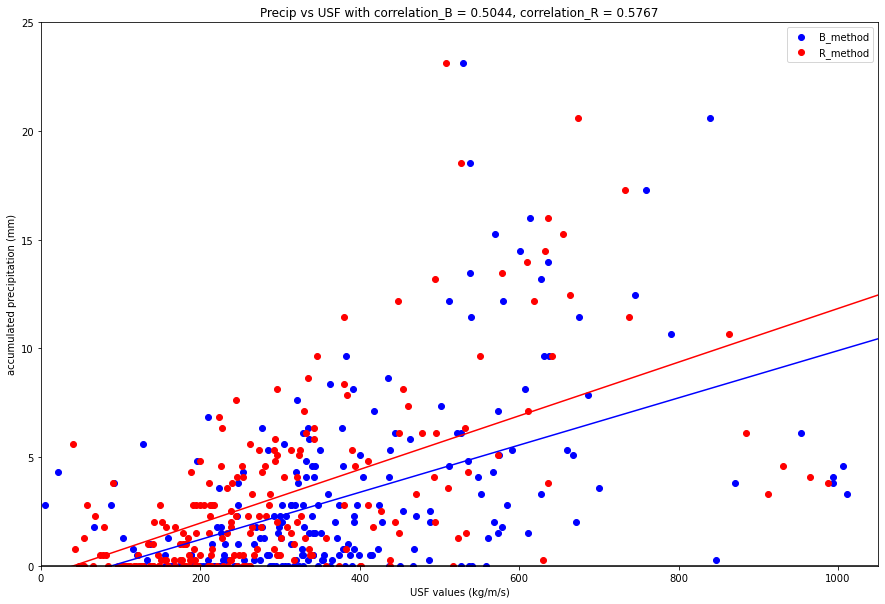

In [11]:
#here we plot the relationship for both methods where x is our USF values and y is the precipitation
y = p_period_RS[p_period_RS > -1]
x = USF_B_list[p_period_RS > -1]
x_Ralph = USF_R_list[p_period_RS > -1]

plt.figure(figsize=(15,10))
plt.scatter(x,y,label = 'B_method', color = 'b')
plt.scatter(x_Ralph,y, label = 'R_method', color = 'r')
plt.plot(np.arange(0,1100),np.arange(0,1100)*m_B + b_B, color='b')
plt.plot(np.arange(0,1100),np.arange(0,1100)*m_R + b_R, color='r')
plt.axhline(y=0, color='k', linestyle='-')
plt.xlabel('USF values (kg/m/s)')
plt.ylabel('accumulated precipitation (mm)')
plt.title('Precip vs USF with correlation_B = {}, correlation_R = {}'
          .format(round(correlation_B,4),round(correlation_R,4)))
plt.xlim(0,1050)
plt.ylim(0,25)
plt.legend()
plt.show()

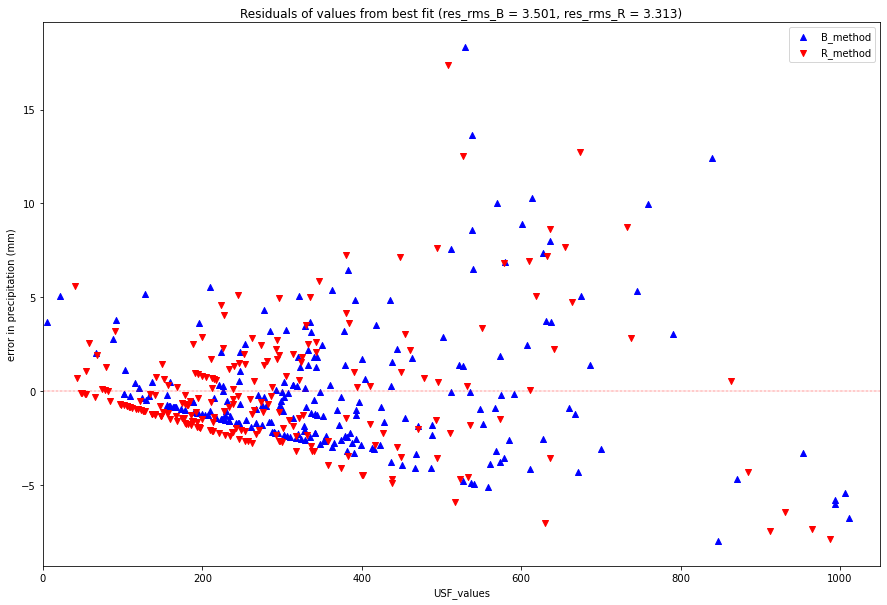

In [12]:
plt.figure(figsize=(15,10))
plt.scatter(x,res_B,label='B_method', color = 'b', marker = '^')
plt.scatter(x_Ralph,res_R,label='R_method', color = 'r',marker = 'v')
plt.ylabel("error in precipitation (mm)")
plt.xlabel("USF_values")
plt.title('Residuals of values from best fit (res_rms_B = {}, res_rms_R = {})'
         .format(round(res_rms_B,3),round(res_rms_R,3)))
plt.axhline(0,color='r',linewidth=0.4,ls='-.')
plt.xlim(0,1050)
plt.legend()
plt.show()

#### plotting average of profiles

In [13]:
#also, here is an example of plotting the average of layers for the interpolated profiles
Tk_avg = np.zeros(len(Tk_in[0]))

#the shape of Tk_in is (342, 70001) so we iterate over the number of columns
#and then take the mean of the 342 values for each column
for ii in range(len(Tk_in[0])):
    Tk_avg[ii] = np.mean(Tk_in[:,ii])

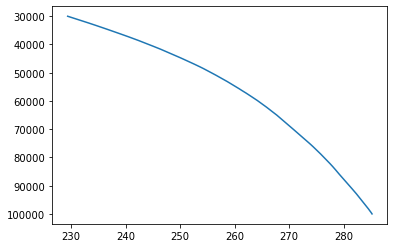

In [14]:
plt.plot(Tk_avg,p_in[0])
plt.gca().invert_yaxis()
plt.show()

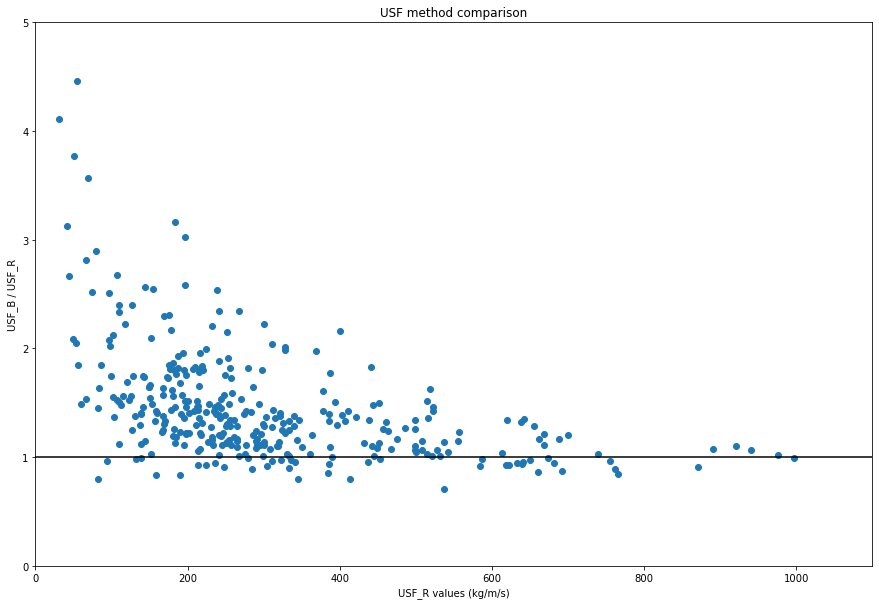

In [15]:
#using the above example you could also compare different USF_methods
#so we will make a list of values of how big USF_B is compared to USF_R
Ralph_predict = USF_B_in/USF_R_in

plt.figure(figsize=(15,10))
plt.scatter(USF_R_in,Ralph_predict)
plt.axhline(y=1, color='k', linestyle='-')
plt.xlabel('USF_R values (kg/m/s)')
plt.ylabel('USF_B / USF_R')
plt.title('USF method comparison')
plt.xlim(0,1100)
plt.ylim(0,5)
plt.show()

In [16]:
#then, for example, we can say we want to see what the temperature is like for values that are high
#and values that are close to unity.
#We will grab the indices that correspond to each, 
Ralph_precise_ind = (Ralph_predict < 1.5)
Ralph_imprecise_ind = (Ralph_predict >= 1.5)

Tk_precise = Tk_in[Ralph_precise_ind]
Tk_imprecise = Tk_in[Ralph_imprecise_ind]

Tk_avg_precise = np.zeros(len(Tk_precise[0]))
for ii in range(len(Tk_precise[0])):
    Tk_avg_precise[ii] = np.mean(Tk_precise[:,ii])

Tk_avg_imprecise = np.zeros(len(Tk_imprecise[0]))
for ii in range(len(Tk_precise[0])):
    Tk_avg_imprecise[ii] = np.mean(Tk_imprecise[:,ii])

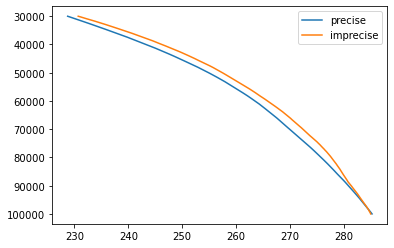

In [17]:
#then we plot them. This of course is not a good method of analysis, we are measuring all values of 
#the USF which creates biases and we arbitrarily pick our threshold for what constitues precision.
#See the matlab code and report for further examples.

plt.plot(Tk_avg_precise,p_in[0], label = 'precise')
plt.plot(Tk_avg_imprecise,p_in[0], label = 'imprecise')
plt.gca().invert_yaxis()
plt.legend()
plt.show()